This is an attempt at recreating my Matlab balloon model code in Python...my first Python code!

In [2]:
# import the libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.interpolate import interp1d
from scipy.integrate import ode


Functions for getting neural response from stimulus

In [3]:
# neural equation

def neureq(t,I,params):

    kappa1, tau, N0, stim, time = params
    f = interp1d(time, stim, kind='nearest')
    newstim = f(t)   
    N = newstim - I
    if N>-N0:
        deriv = (kappa1*N-I)/tau
    else:
        deriv = (-kappa1*N0-I)/tau # neural response cannot go below 0

    return deriv




# make the neural model function

def StimulusToNeural(protocol,deltat,const):
    
    # default parameter values
    kappa1 = 2; # (0-3)
    tau = 2; # (1-3)
    N0 = 0;

    timing = [deltat*i for i in range(len(protocol))] # time vector
    newtiming = np.arange(0,max(timing),0.05) # higher sampling
    
    f = interp1d(timing, protocol, kind='nearest')
    newstim = [f(i) for i in newtiming]   
    newstim = newstim*const

    I0 = -N0;

    # Bundle parameters for ODE solver
    params = [kappa1, tau, N0, newstim, newtiming]

    # Make time array for solution
    tInc = 0.05
    t = np.arange(newtiming[0], newtiming[-1], tInc)

    # Call the ODE solver
    # psoln = odeint(systemeq, y0, t, args=(params,))
    solver = ode(neureq).set_integrator("dop853")
    solver.set_initial_value(I0).set_f_params(params)

    k = 0
    soln = [I0]
    while solver.successful() and solver.t < t[-1]:
        k += 1
        solver.integrate(t[k])
        soln.append(solver.y)

    # Convert the list to a numpy array.
    I = np.array(soln)
    f = interp1d(newtiming, newstim, kind='nearest')
    newstim = f(t)   
    neur = newstim-I;
    neur[neur<0] = 0; # imposes that N0+N>=0
        
    
    return t, neur


In [4]:
# make the function that converts neural response to flow in the vasculature

def floweq(t,y,params):
    x1, x2 = y
    kappa2, gamma, neuronalact, timing = params
    f = interp1d(timing, neuronalact)
    neuronal = f(t)
    derivs = [x2, 
             neuronal-x2*kappa2-(x1-1)*gamma]

    

def NeuraltoFlow(timing,neuralresp):
    
    kappa2 = .65; # prior from the paper: 0.65
    gamma = .41; # prior from the paper: 0.41


    # Bundle parameters for ODE solver
    params = [kappa2, gamma, neuralresp, timing]

    # Bundle initial conditions for ODE solver
    f0 = 1; # flow in to vasculature
    s0 = 0; # signal to the vasulature
    y0 = [f0, s0]

    # Make time array for solution
    tInc = 0.05
    t = np.arange(timing[0], timing[-1], tInc)

    # Call the ODE solver
    # psoln = odeint(systemeq, y0, t, args=(params,))
    solver = ode(floweq).set_integrator("dopri5")
    solver.set_initial_value(y0).set_f_params(params)

    k = 0
    soln = [y0]
    while solver.successful() and solver.t < t[-1]:
        k += 1
        solver.integrate(t[k])
        soln.append(solver.y)

    # Convert the list to a numpy array.
    psoln = np.array(soln)
        
    
    flow = psoln[:,0]
    vascsignal = psoln[:,1]

    return t, flow, vascsignal

Set up all of the Balloon Model functions

In [5]:
# equation for oxygen extraction


def Eeq(E0,flowin):
    E = 1-(1-E0)**(1/flowin);
    return E


In [6]:
# balloon model parameter function

def balloonparameter(TE,B0,E0,V0):

    if B0==3:
        r0 = 108
    elif B0==1.5:
        r0 = 15
    else:
        print("""Parameter value for r0 isn't available for the field strength specified, using approximation""")
        r0 = 25 *(B0/1.5)^2 # not sure where Pinglei got this from, but seems approximately correct

    if (B0==3 or B0==1.5):
        epsilon = 0.13 # assuming dominance of macrovascular component
    else:
        raise ValueError('Parameter value for epsilon is not available for the field strength specified')

    v = 40.3 * (B0/1.5)

    k1 = 4.3 * v * E0 * TE
    k2 = epsilon*r0*E0*TE
    k3 = 1 - epsilon

    return (k1, k2, k3, V0, E0)


# system of differential equations for balloon model

def systemeq(t,y,params):
    x1, x2 = y
    tau1, tau2, alpha, E0, flowin, timing = params
    f = interp1d(timing, flowin)
    fin = f(t)
    E = Eeq(E0,fin)
    derivs = [(1/tau1)*(fin*E/E0-x1/x2*(x2**(1/alpha)+tau2/(tau1+tau2)*(fin-x2**(1/alpha)))),
             1/(tau1+tau2)*(fin-(x2**(1/alpha)))]
    return derivs




# make the balloon model function

def BalloonModel(timing,flowin,TE):
    
  
    alpha = .4; # 0.32 in Friston
    E0 = 0.4;
    V0 = 0.03; # 0.03 in Buxton, Uludag, et al.
    F0 = 0.01;
    tau2 = 30; # typical value based on fits from Mildner, Norris, Schwarzbauer, and Wiggins (2001)
    B0 = 3; # we have a 3 T scanner!    
    tau1 = V0/F0;
    k1, k2, k3, V0, E0 = balloonparameter(TE,B0,E0,V0);
    q0 = 1;
    v0 = 1;
    V0 = V0;

    # Bundle parameters for ODE solver
    params = [tau1, tau2, alpha, E0, flowin, timing]

    # Bundle initial conditions for ODE solver
    y0 = [q0, v0]

    # Make time array for solution
    tInc = 0.05
    t = np.arange(timing[0], timing[-1], tInc)

    # Call the ODE solver
    # psoln = odeint(systemeq, y0, t, args=(params,))
    solver = ode(systemeq).set_integrator("dop853")
    solver.set_initial_value(y0).set_f_params(params)

    k = 0
    soln = [y0]
    while solver.successful() and solver.t < t[-1]:
        k += 1
        solver.integrate(t[k])
        soln.append(solver.y)

    # Convert the list to a numpy array.
    psoln = np.array(soln)
        
    
    q = psoln[:,0]
    v = psoln[:,1]
    bold = V0*(k1*(1-q)+k2*(1-q/v)+k3*(1-v))


    return (t, bold, q, v)



Test the model for a simple block design

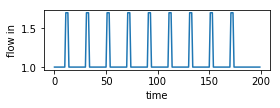

In [7]:
# parameters

timing = np.linspace( 0, 199, 200 )
TE = 0.03;
flowin = np.ones(200)
#plotdata = False;
for x in range(0, int(200/20)-1):
    flowin[x*20+11:x*20+15-1] = 1.7

protocol = flowin-1
deltat = 1
const = 1
    
    
# plot the flow in
fig = plt.figure(1, figsize=(4,4))
ax1 = fig.add_subplot(311)
ax1.plot(timing, flowin)
ax1.set_xlabel('time')
ax1.set_ylabel('flow in')
plt.tight_layout()
plt.show()



In [8]:

# run it


# stimulus to neural response
tneur, neur = StimulusToNeural(protocol,deltat,const)
timing = [deltat*i for i in range(len(protocol))] # time vector
    

# neural to flow in
# tflowin, flowin, vascsignal = NeuraltoFlow(tneur,neur)


# flow in to BOLD
t, resp, q, v = BalloonModel(timing,flowin,TE)





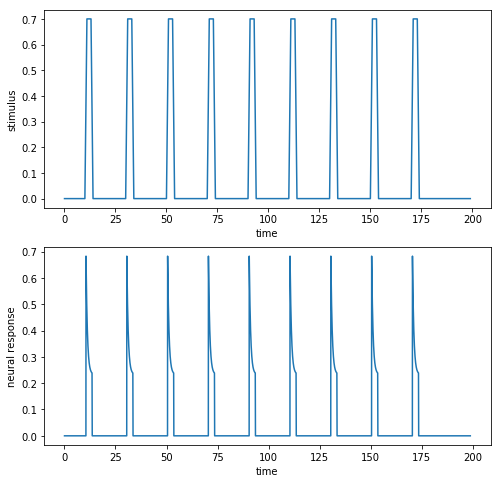

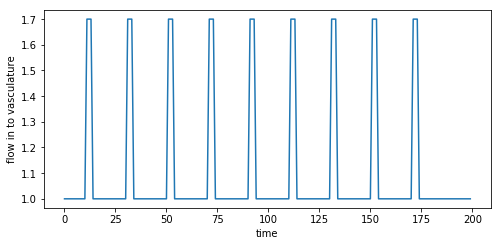

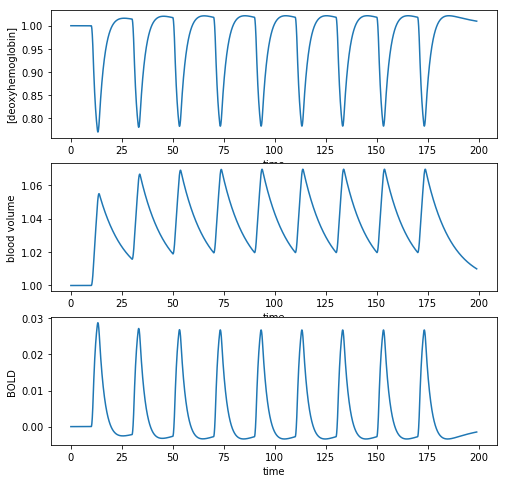

In [9]:
# plot it

# Stim and neural response
fig1 = plt.figure(1, figsize=(8,8))

# Plot the stimulus
ax1 = fig1.add_subplot(211)
ax1.plot(timing, protocol)
ax1.set_xlabel('time')
ax1.set_ylabel('stimulus')

# Plot the neural response
ax2 = fig1.add_subplot(212)
ax2.plot(tneur, neur)
ax2.set_xlabel('time')
ax2.set_ylabel('neural response')

plt.show()

# NEURAL TO FLOW IN PROGRESS, NOT YET WORKING

# neurovascular signal and flow
fig2 = plt.figure(1, figsize=(8,8))

## Plot the signal to the vasculature
#ax1 = fig2.add_subplot(211)
#ax1.plot(tflowin, vascsignal)
#ax1.set_xlabel('time')
#ax1.set_ylabel('signal to vasculature')

# Plot the neural response
ax2 = fig2.add_subplot(212)
ax2.plot(timing, flowin)
ax2.set_xlabel('time')
ax2.set_ylabel('flow in to vasculature')

plt.show()

# Balloon model plots
fig3 = plt.figure(1, figsize=(8,8))

# Plot dexoyhem conc as a function of time
ax1 = fig3.add_subplot(311)
ax1.plot(t, q)
ax1.set_xlabel('time')
ax1.set_ylabel('[deoxyhemoglobin]')

# Plot volume as a function of time
ax2 = fig3.add_subplot(312)
ax2.plot(t, v)
ax2.set_xlabel('time')
ax2.set_ylabel('blood volume')

# Plot BOLD as a function of time
ax3 = fig3.add_subplot(313)
ax3.plot(t, resp)
ax3.set_xlabel('time')
ax3.set_ylabel('BOLD')

# plt.tight_layout()
plt.show()

